<a href="https://colab.research.google.com/github/JH-Y-324/first-repository/blob/master/AARRR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving customer_fact.csv to customer_fact.csv
Saving olist_products_dataset.csv to olist_products_dataset.csv
Saving order_fact.csv to order_fact.csv
Saving product_category_name_translation.csv to product_category_name_translation.csv


In [ ]:
import pandas as pd

In [ ]:
customer = pd.read_csv('customer_fact.csv')
order = pd.read_csv('order_fact.csv')
products = pd.read_csv('olist_products_dataset.csv')
category = pd.read_csv('product_category_name_translation.csv')

In [ ]:
order.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'customer_unique_id', 'items_cnt', 'items_price', 'freight_value',
       'products_cnt', 'sellers_cnt', 'last_shipping_limit_date',
       'payment_value', 'max_installments', 'payment_types', 'review_score',
       'has_review', 'first_review_date', 'last_review_date',
       'flag_missing_items', 'is_delivered', 'order_rank', 'is_first_order'],
      dtype='object')

In [ ]:
order['order_purchase_timestamp'] = pd.to_datetime(
    order['order_purchase_timestamp']
)

order = order.sort_values(
    ['customer_unique_id','order_purchase_timestamp','order_id']
)

order['order_rank'] = (
    order.groupby('customer_unique_id').cumcount() + 1
)

order['is_first_order'] = (order['order_rank'] == 1).astype(int)

In [ ]:
order.groupby('customer_unique_id')['is_first_order'].sum().describe()

,is_first_order
count,96096.0
mean,1.0
std,0.0
min,1.0
25%,1.0
50%,1.0
75%,1.0
max,1.0


In [ ]:
order.loc[order['is_first_order']==1, 'is_delivered'].mean()

np.float64(0.9704462204462204)

In [ ]:
order['is_first_order'].value_counts(normalize=True)

,proportion
is_first_order,
1,0.966362
0,0.033638


In [ ]:
order.to_csv('order_fact.csv', index=False)

In [ ]:
from google.colab import files
files.download('order_fact.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
order.loc[order['is_first_order'] == 1, 'is_delivered'].mean()

np.float64(0.9704462204462204)

In [ ]:
import pandas as pd
import numpy as np

# order_purchase_timestamp가 datetime인지 확인 (아니면 변환)
order['order_purchase_timestamp'] = pd.to_datetime(order['order_purchase_timestamp'], errors='coerce')

In [ ]:
order = order.sort_values(['customer_unique_id','order_purchase_timestamp','order_id'])

order['first_purchase_ts'] = (
    order.groupby('customer_unique_id')['order_purchase_timestamp']
    .transform('min')
)

# 첫 구매 이후 경과일(리텐션용)
order['days_since_first'] = (
    (order['order_purchase_timestamp'] - order['first_purchase_ts'])
    .dt.days
)

# 코호트 월
order['cohort_month'] = order['first_purchase_ts'].dt.to_period('M').dt.to_timestamp()

In [ ]:
# cust_orders = order.groupby('customer_unique_id').agg(
#     cohort_month=('cohort_month','first'),
#     orders_cnt=('order_id','nunique')
# ).reset_index()

# repeat_rate_by_cohort = cust_orders.groupby('cohort_month').agg(
#     cohort_customers=('customer_unique_id','nunique'),
#     repeat_rate=('orders_cnt', lambda s: (s >= 2).mean())
# ).reset_index().sort_values('cohort_month')

# repeat_rate_by_cohort.head()

,cohort_month,cohort_customers,repeat_rate
0,2016-09-01,4,0.000000
1,2016-10-01,321,0.037383
2,2016-12-01,1,1.000000
3,2017-01-01,764,0.075916
4,2017-02-01,1752,0.041667


In [ ]:
repeat_rate_by_cohort_filtered = repeat_rate_by_cohort[
    repeat_rate_by_cohort['cohort_customers'] >= 100
]

In [ ]:
repeat_rate_by_cohort_filtered['repeat_rate_pct'] = (
    repeat_rate_by_cohort_filtered['repeat_rate'] * 100
)

/tmp/ipython-input-2842037453.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  repeat_rate_by_cohort_filtered['repeat_rate_pct'] = (


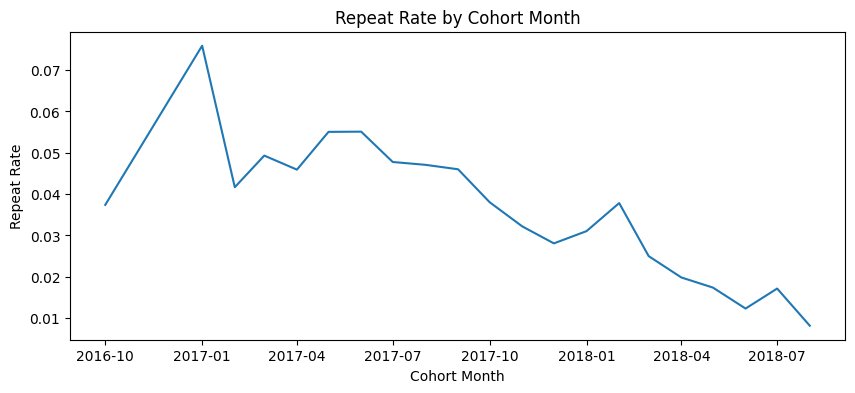

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(
    repeat_rate_by_cohort_filtered['cohort_month'],
    repeat_rate_by_cohort_filtered['repeat_rate']
)
plt.title('Repeat Rate by Cohort Month')
plt.ylabel('Repeat Rate')
plt.xlabel('Cohort Month')
plt.show()

In [ ]:
repeat_rate_by_cohort_filtered.head()

,cohort_month,cohort_customers,repeat_rate,repeat_rate_pct
1,2016-10-01,321,0.037383,3.738318
3,2017-01-01,764,0.075916,7.591623
4,2017-02-01,1752,0.041667,4.166667
5,2017-03-01,2636,0.049317,4.931715
6,2017-04-01,2352,0.045918,4.591837


In [ ]:
ret_flags = order.groupby('customer_unique_id').agg(
    cohort_month=('cohort_month','first'),
    rolling_7d=('days_since_first', lambda s: int((s >= 7).any())),
    rolling_30d=('days_since_first', lambda s: int((s >= 30).any()))
).reset_index()

rolling_by_cohort = ret_flags.groupby('cohort_month').agg(
    cohort_customers=('customer_unique_id','nunique'),
    rolling_7d=('rolling_7d','mean'),
    rolling_30d=('rolling_30d','mean')
).reset_index().sort_values('cohort_month')

rolling_by_cohort.head()

,cohort_month,cohort_customers,rolling_7d,rolling_30d
0,2016-09-01,4,0.000000,0.000000
1,2016-10-01,321,0.028037,0.028037
2,2016-12-01,1,1.000000,0.000000
3,2017-01-01,764,0.044503,0.039267
4,2017-02-01,1752,0.031963,0.027397
